In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
image2 = './images/sub-002/rgb1.png'
depth1 = './images/sub-002/depth1.png'
image1 = './images/sub-002/rgb2.png'
depth2 = './images/sub-002/depth2.png'



In [25]:
# load images 
img1 = cv2.imread(image1)
img2 = cv2.imread(image2)

# convert to greyscale
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

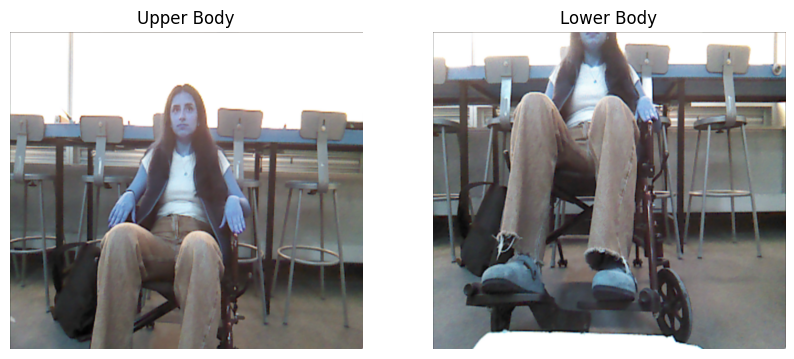

In [27]:
# display greyscale images

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].set_title("Upper Body")
axes[0].axis("off")

axes[1].imshow(img2)
axes[1].set_title("Lower Body")
axes[1].axis("off")

plt.show()

In [29]:
if img1.shape[1] != img2.shape[1]:
    new_width = min(img1.shape[1], img2.shape[1])
    upper = cv2.resize(img1, (new_width, int(img1.shape[0] * new_width / img1.shape[1])))
    lower = cv2.resize(img2, (new_width, int(img2.shape[0] * new_width / img2.shape[1])))


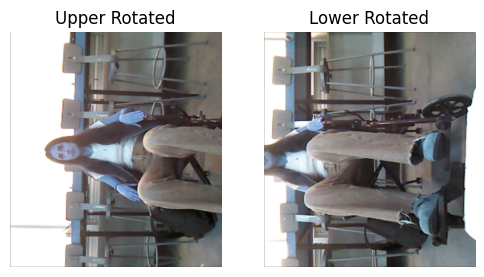

In [32]:
# Rotate 90 degrees counterclockwise
img1_rot = cv2.rotate(upper, cv2.ROTATE_90_COUNTERCLOCKWISE)
img2_rot = cv2.rotate(lower, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
plt.imshow(img1_rot)
plt.title("Upper Rotated")
plt.axis("off")

# Optional: show rotated images
plt.subplot(1,2,2)
plt.imshow(img2_rot)
plt.title("Lower Rotated")
plt.axis("off")
plt.show()


In [ ]:
# orb method 
orb = cv2.ORB_create(5000)

# Find keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1_rot, None)
kp2, des2 = orb.detectAndCompute(img2_rot, None)

# ORB uses Hamming
# this is brute force matching 
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# select good matches and compute homography
good_matches = matches[:int(len(matches)*0.4)]  # top 40%
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)

# warp lower image into upper image 
h1, w1 = img1_rot.shape[:2]
h2, w2 = img2_rot.shape[:2]

# Compute size for horizontal matching
corners_lower = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(corners_lower, H)
all_corners = np.concatenate((np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2),
                              warped_corners), axis=0)
[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())
trans = [-xmin, -ymin]
H_trans = np.array([[1,0,trans[0]],[0,1,trans[1]],[0,0,1]])

result = cv2.warpPerspective(img2_rot, H_trans.dot(H), (xmax-xmin, ymax-ymin))
result[trans[1]:trans[1]+h1, trans[0]:trans[0]+w1] = img1_rot

# smooth overlap
overlap = 30
for y in range(trans[1], trans[1]+overlap):
    alpha = (y - trans[1]) / overlap
    result[y, trans[0]:trans[0]+w1] = (alpha*img1_rot[y-trans[1]] + (1-alpha)*result[y, trans[0]:trans[0]+w1]).astype(np.uint8)


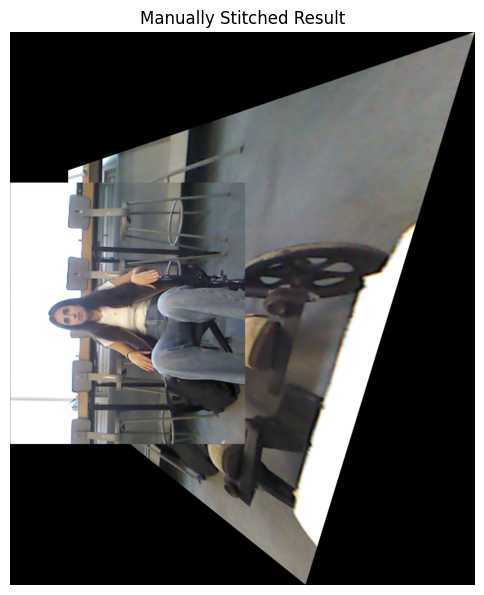

True

In [35]:
plt.figure(figsize=(6,10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Manually Stitched Result")
plt.show()

cv2.imwrite("stitched_manual.jpg", result)

In [ ]:
# sticher class does not work well for people - cant find enough features

stitcher = cv2.Stitcher_create()
status, stitched = stitcher.stitch([img2_rot, img1_rot])

if status == cv2.Stitcher_OK:
    print("Stitching successful!")
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Stitched Result")
    plt.show()
else:
    print("Stitching failed. Error code:", status)


Stitching failed. Error code: 1


Found 59 good matches


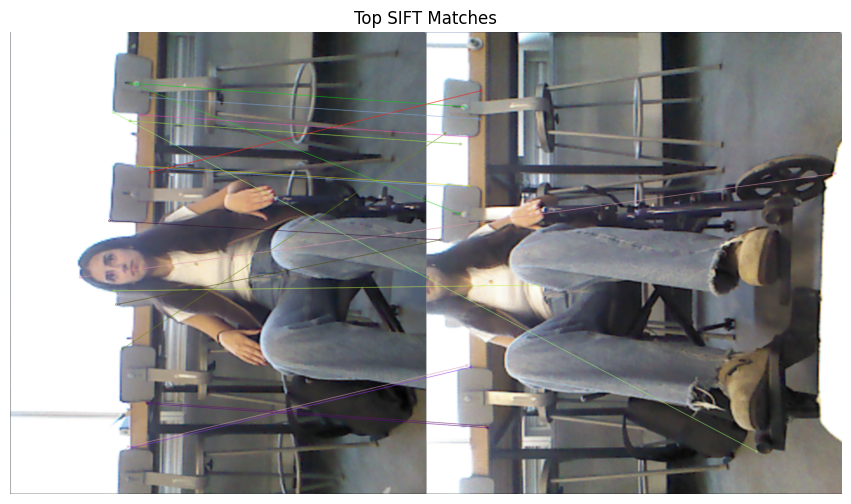

In [38]:
# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1_rot, None)
kp2, des2 = sift.detectAndCompute(img2_rot, None)

# Use FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# Ratio test (Lowe's ratio)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Found {len(good_matches)} good matches")

if len(good_matches) < 8:
    raise RuntimeError("Not enough good matches to compute homography")

# Draw top matches (optional for debugging)
img_matches = cv2.drawMatches(img1_rot, kp1, img2_rot, kp2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Top SIFT Matches")
plt.axis("off")
plt.show()

# Extract matched points
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

# Compute homography using RANSAC
H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)

# Warp lower image onto upper image coordinates
h1, w1 = img1_rot.shape[:2]
h2, w2 = img2_rot.shape[:2]

# Corners of both images
corners_upper = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
corners_lower = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

# Warp lower corners to upper image coordinate system
warped_corners_lower = cv2.perspectiveTransform(corners_lower, H)

# Combine all corners to get the full bounding box
all_corners = np.concatenate((corners_upper, warped_corners_lower), axis=0)
[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
trans = [-xmin, -ymin]  # shift everything so coordinates are positive
H_trans = np.array([[1,0,trans[0]],
                    [0,1,trans[1]],
                    [0,0,1]])

# Warp the lower image
result = cv2.warpPerspective(img1_rot, H_trans.dot(H), (xmax-xmin, ymax-ymin))

# Paste upper image in the correct location
result[trans[1]:trans[1]+h1, trans[0]:trans[0]+w1] = img2_rot




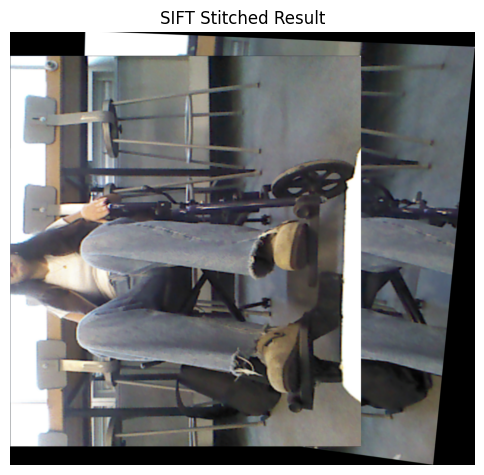

True

In [39]:
plt.figure(figsize=(6,10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("SIFT Stitched Result")
plt.show()

cv2.imwrite("stitched_sift.jpg", result)

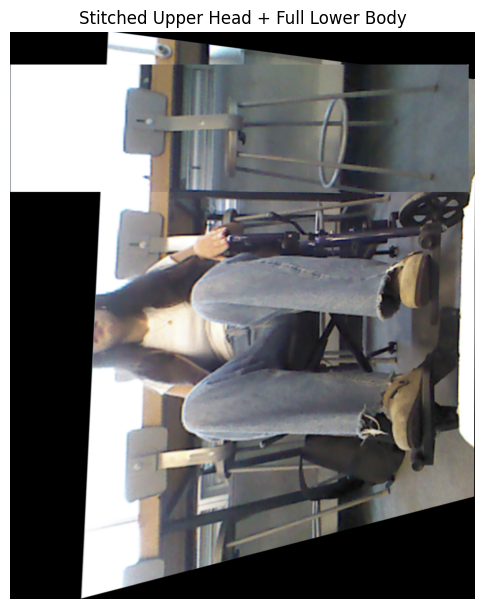

True

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image2 = './images/sub-002/rgb1.png'
depth1 = './images/sub-002/depth1.png'
image1 = './images/sub-002/rgb2.png'
depth2 = './images/sub-002/depth2.png'

# Load and rotate images
img_upper = cv2.imread(image1)
img_lower = cv2.imread(image2)
img_upper = cv2.rotate(img_upper, cv2.ROTATE_90_COUNTERCLOCKWISE)
img_lower = cv2.rotate(img_lower, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Convert to grayscale
gray_upper = cv2.cvtColor(img_upper, cv2.COLOR_BGR2GRAY)
gray_lower = cv2.cvtColor(img_lower, cv2.COLOR_BGR2GRAY)

# --- Step 1: Detect SIFT keypoints and descriptors ---
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_upper, None)
kp2, des2 = sift.detectAndCompute(gray_lower, None)

# --- Step 2: Match features with FLANN + ratio test ---
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)

if len(good_matches) < 8:
    raise RuntimeError("Not enough good matches")

# --- Step 3: Compute homography ---
pts_upper = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
pts_lower = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
H, mask = cv2.findHomography(pts_lower, pts_upper, cv2.RANSAC, 5.0)

# --- Step 4: Warp lower body image ---
h1, w1 = img_upper.shape[:2]
h2, w2 = img_lower.shape[:2]

corners_lower = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(corners_lower, H)
all_corners = np.concatenate((np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2), warped_corners), axis=0)

[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
trans = [-xmin, -ymin]
H_trans = np.array([[1,0,trans[0]],[0,1,trans[1]],[0,0,1]])

result = cv2.warpPerspective(img_lower, H_trans.dot(H), (xmax-xmin, ymax-ymin))

# --- Step 5: Overlay only the head of the upper body ---
head_height = int(h1 * 0.25)  # adjust this fraction to include just the head
result[trans[1]:trans[1]+head_height, trans[0]:trans[0]+w1] = img_upper[:head_height, :, :]

# --- Step 6: Show result ---
plt.figure(figsize=(6,10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Stitched Upper Head + Full Lower Body")
plt.show()

cv2.imwrite("full_lower_stitched.jpg", result)